In [ ]:
!pip install keras==2.15.0
!pip show tensorflow
!pip show keras

# Import thư viện & Set up

In [2]:
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from keras.callbacks import LearningRateScheduler
from tensorflow import keras

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import os
import numpy as np
import pandas as pd
from PIL import Image

image_dir = "/kaggle/input/fooddata20/VN20-500"
pretrained_model = "/kaggle/input/mobilenetv2/mobile.h5"
if not os.path.exists('/kaggle/working/history'):
    os.makedirs('/kaggle/working/history')
class_labels = sorted(list(os.listdir(image_dir+'/Train')))
print(class_labels)

2024-06-03 11:40:45.761700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 11:40:45.761803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 11:40:45.893407: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['Banh_Beo', 'Banh_Can', 'Banh_Gio', 'Banh_Mi', 'Banh_Trang_Nuong', 'Banh_Xeo', 'Bap_Xao', 'Bun_Bo', 'Bun_Cha', 'Bun_Dau', 'Bun_Mam', 'Bun_Thit_Nuong', 'Cao_Lau', 'Chao_Long', 'Com_Tam', 'Goi_Cuon', 'Hu_Tieu', 'Mi_Quang', 'Pha_Lau', 'Pho', 'Unknown']


In [3]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(10, 2))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


def plot_f1_scores(y_true, y_pred, class_labels):
    f1_scores = []

    # Calculate F1 score for each class
    for class_label in range(len(class_labels)):
        true_class = (y_true == class_label)
        predicted_class = (y_pred == class_label)
        f1 = f1_score(true_class, predicted_class)
        f1_scores.append(f1)

    # Create a bar chart for F1 scores
    plt.figure(figsize=(10, 5))
    plt.bar(class_labels, f1_scores)
    plt.xlabel('Class Labels')
    plt.ylabel('F1 Score')
    plt.title('F1 Score by Class')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)

train_generator = datagen.flow_from_directory(
    directory = image_dir+'/Train',
    target_size=(299, 299),
    batch_size=128,
    class_mode='categorical',
    shuffle=True,
)

validation_generator = datagen.flow_from_directory(
    directory = image_dir+'/Validation',
    target_size=(299, 299),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)
test_generator = datagen.flow_from_directory(
    image_dir+'/Test',
    target_size=(299, 299),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

Found 7720 images belonging to 21 classes.
Found 1037 images belonging to 21 classes.
Found 2080 images belonging to 21 classes.


In [5]:

def get_model_instance(model, img_shape):
    base_model = model(
        input_shape=img_shape,
        include_top=False,
        weights='imagenet'
    )
    
    base_model.trainable = False

    new_model = models.Sequential([
        base_model,
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(21, activation='softmax')
    ])
 

    new_model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

 
    new_model.summary()

    return new_model

In [6]:
def training(model, filename):
    best_model = f'experiment/{filename}.h5'

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples/train_generator.batch_size,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples/validation_generator.batch_size,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                min_delta=0.1
            ),
            tf.keras.callbacks.ModelCheckpoint(best_model, save_best_only=True)
        ]
    )

    model.save(f'/kaggle/working/final/{filename}.h5')

    history_df = pd.DataFrame(history.history)
    history_df.to_csv(f'history/{filename}.csv', index=False)
    return model, history

In [7]:
def evaluation(model):
    test_loss, test_accuracy = model.evaluate(
        test_generator,
        steps=len(test_generator)
    )
    print("Loss", test_loss)
    print("Accuracy", test_accuracy)
    predictions = model.predict(test_generator)

    # Convert predicted probabilities to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Get true labels from the generator
    true_labels = test_generator.classes

    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    print('F1 score:', f1)

    plot_f1_scores(true_labels, predicted_labels, class_labels)

# Inception _V3

In [8]:
from tensorflow.keras.applications import InceptionV3

inception = get_model_instance(InceptionV3, (299, 299, 3))

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 conv2d_94 (Conv2D)          (None, 8, 8, 64)          1179712   
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (  (None, 64)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                         

In [9]:
inception , history = training(inception , 'inception')

Epoch 1/30


I0000 00:00:1715147721.513046     130 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


61/60 [==============================] - ETA: -1s - loss: 2.1090 - accuracy: 0.3627

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 224s 3s/step - loss: 2.1090 - accuracy: 0.3627 - val_loss: 1.2926 - val_accuracy: 0.6403
Epoch 2/30
60/60 [==============================] - 170s 3s/step - loss: 1.2727 - accuracy: 0.6053 - val_loss: 0.9611 - val_accuracy: 0.7338
Epoch 3/30
60/60 [==============================] - 167s 3s/step - loss: 1.0059 - accuracy: 0.6889 - val_loss: 0.8169 - val_accuracy: 0.7715
Epoch 4/30
60/60 [==============================] - 168s 3s/step - loss: 0.8455 - accuracy: 0.7421 - val_loss: 0.7565 - val_accuracy: 0.7811
Epoch 5/30
60/60 [==============================] - 170s 3s/step - loss: 0.7451 - accuracy: 0.7683 - val_loss: 0.7136 - val_accuracy: 0.7946
Epoch 6/30
60/60 [==============================] - 179s 3s/step - loss: 0.6661 - accuracy: 0.7918 - val_loss: 0.6677 - val_accuracy: 0.8042
Epoch 7/30
60/60 [==============================] - 170s 3s/step - loss: 0.5983 - accuracy: 0.8136 - val_loss: 0.6405 - val_accuracy: 0.8129
Epoch 8/30
60/60 [======

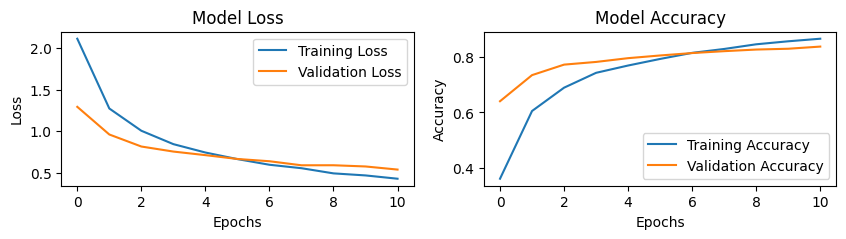

In [10]:
plot_training_history(history.history)

 5/17 [=======>......................] - ETA: 24s - loss: 0.2550 - accuracy: 0.9266

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


17/17 [==============================] - 42s 3s/step - loss: 0.5394 - accuracy: 0.8298
Loss 0.5394210815429688
Accuracy 0.829807698726654
17/17 [==============================] - 32s 2s/step
F1 score: 0.8303881363297183


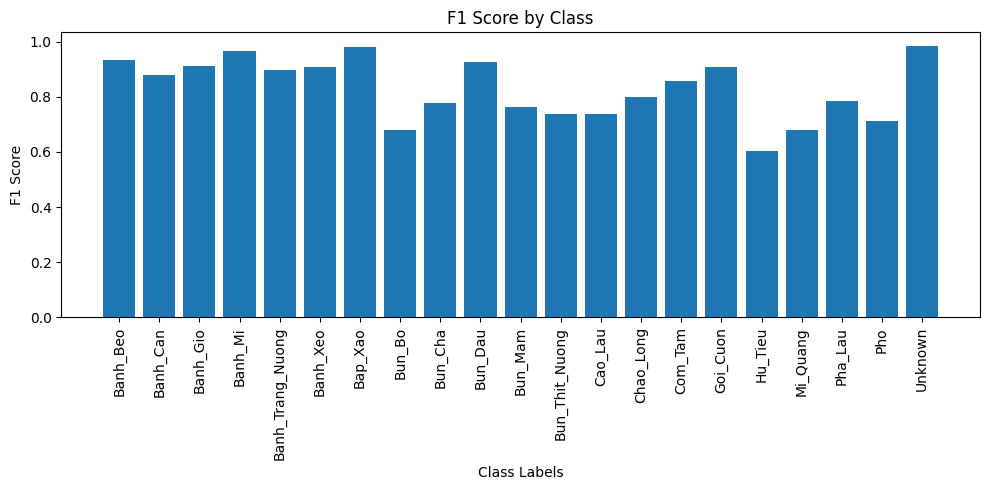

In [11]:
evaluation(inception)

# Xception

In [12]:
from tensorflow.keras.applications import Xception

xcep = get_model_instance(Xception, (299, 299, 3))

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 conv2d_99 (Conv2D)          (None, 10, 10, 64)        1179712   
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_1  (None, 64)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                       

In [13]:
xcep , history = training(xcep , 'xcep')

Epoch 1/30
61/60 [==============================] - ETA: -1s - loss: 2.1494 - accuracy: 0.3947

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 179s 3s/step - loss: 2.1494 - accuracy: 0.3947 - val_loss: 1.3582 - val_accuracy: 0.6461
Epoch 2/30
60/60 [==============================] - 167s 3s/step - loss: 1.2585 - accuracy: 0.6413 - val_loss: 0.9354 - val_accuracy: 0.7551
Epoch 3/30
60/60 [==============================] - 165s 3s/step - loss: 0.9702 - accuracy: 0.7119 - val_loss: 0.7611 - val_accuracy: 0.8014
Epoch 4/30
60/60 [==============================] - 167s 3s/step - loss: 0.8130 - accuracy: 0.7560 - val_loss: 0.6639 - val_accuracy: 0.8158
Epoch 5/30
60/60 [==============================] - 169s 3s/step - loss: 0.7078 - accuracy: 0.7878 - val_loss: 0.6137 - val_accuracy: 0.8284
Epoch 6/30
60/60 [==============================] - 168s 3s/step - loss: 0.6359 - accuracy: 0.8126 - val_loss: 0.5838 - val_accuracy: 0.8303
Epoch 7/30
60/60 [==============================] - 168s 3s/step - loss: 0.5671 - accuracy: 0.8277 - val_loss: 0.5573 - val_accuracy: 0.8351
Epoch 8/30
60/60 [======

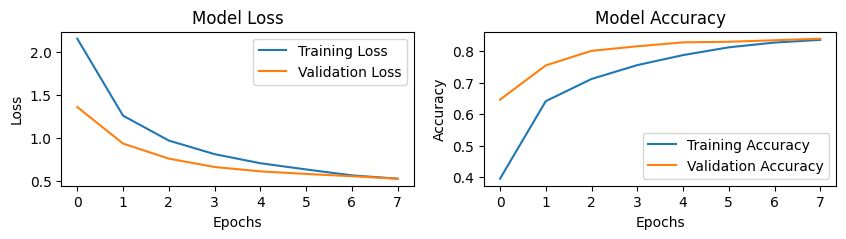

In [14]:
plot_training_history(history.history)

 5/17 [=======>......................] - ETA: 19s - loss: 0.3092 - accuracy: 0.9172

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


17/17 [==============================] - 35s 2s/step - loss: 0.5475 - accuracy: 0.8356
Loss 0.547501266002655
Accuracy 0.8355769515037537
17/17 [==============================] - 32s 2s/step
F1 score: 0.8362313635537871


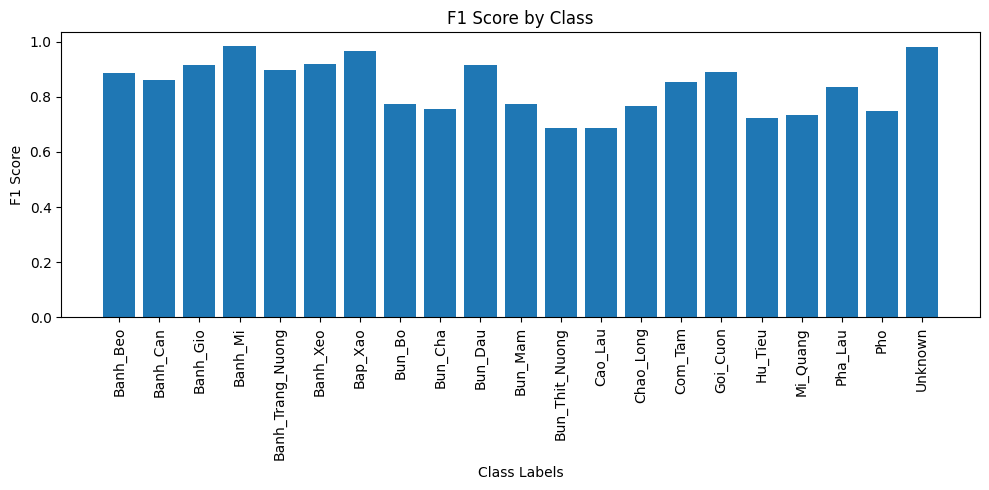

In [15]:
evaluation(xcep)

# MobileNet_v2 


In [16]:
from tensorflow.keras.applications import MobileNetV2

mobilenet = get_model_instance(MobileNetV2, (299, 299, 3))

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 10, 10, 1280)      2257984   
 tional)                                                         
                                                                 
 conv2d_100 (Conv2D)         (None, 10, 10, 64)        737344    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_2  (None, 64)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 128)               83

In [17]:
mobilenet, history = training(mobilenet, 'mobile')

Epoch 1/30
61/60 [==============================] - ETA: -1s - loss: 2.4491 - accuracy: 0.3054

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 171s 3s/step - loss: 2.4491 - accuracy: 0.3054 - val_loss: 1.6109 - val_accuracy: 0.5892
Epoch 2/30
60/60 [==============================] - 161s 3s/step - loss: 1.4797 - accuracy: 0.5703 - val_loss: 1.0704 - val_accuracy: 0.7252
Epoch 3/30
60/60 [==============================] - 163s 3s/step - loss: 1.1153 - accuracy: 0.6696 - val_loss: 0.8419 - val_accuracy: 0.7850
Epoch 4/30
60/60 [==============================] - 163s 3s/step - loss: 0.8793 - accuracy: 0.7347 - val_loss: 0.7157 - val_accuracy: 0.8014
Epoch 5/30
60/60 [==============================] - 159s 3s/step - loss: 0.7428 - accuracy: 0.7762 - val_loss: 0.6244 - val_accuracy: 0.8226
Epoch 6/30
60/60 [==============================] - 160s 3s/step - loss: 0.6355 - accuracy: 0.8109 - val_loss: 0.5729 - val_accuracy: 0.8390
Epoch 7/30
60/60 [==============================] - 162s 3s/step - loss: 0.5504 - accuracy: 0.8369 - val_loss: 0.5377 - val_accuracy: 0.8544
Epoch 8/30
60/60 [======

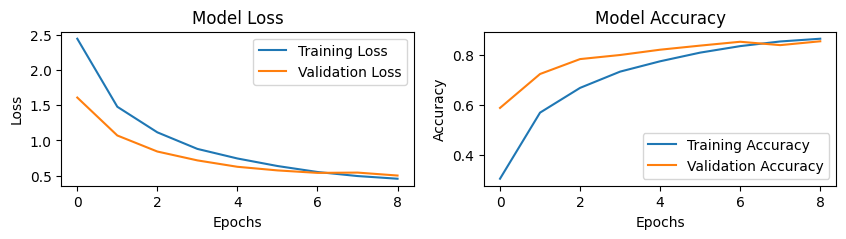

In [18]:
plot_training_history(history.history)

 5/17 [=======>......................] - ETA: 20s - loss: 0.3206 - accuracy: 0.9125

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


17/17 [==============================] - 33s 2s/step - loss: 0.5534 - accuracy: 0.8399
Loss 0.553354024887085
Accuracy 0.8399038314819336
17/17 [==============================] - 31s 2s/step
F1 score: 0.8397610338135207


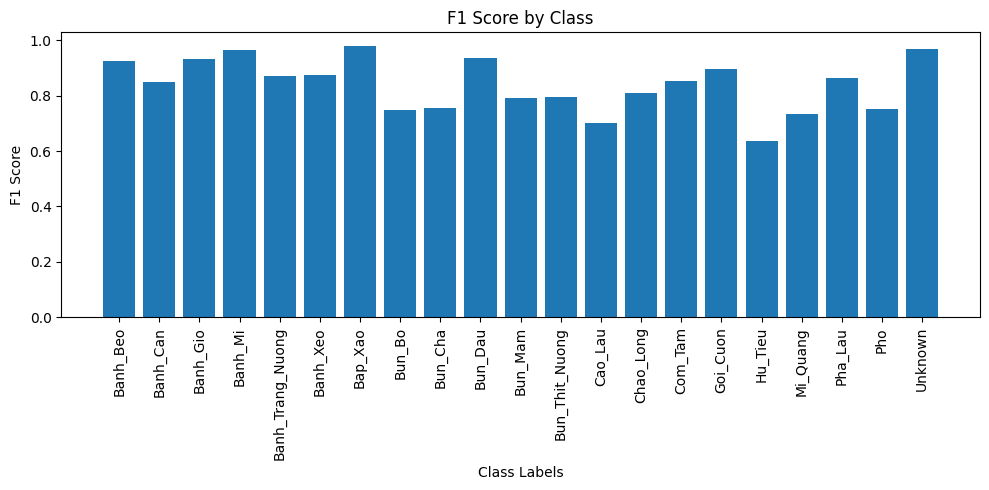

In [19]:
evaluation(mobilenet)

# ResNet152V2

In [20]:
from tensorflow.keras.applications import ResNet152V2

resnet_model = get_model_instance(ResNet152V2, (299, 299, 3))

234545216/234545216 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 10, 10, 2048)      58331648  
                                                                 
 conv2d_101 (Conv2D)         (None, 10, 10, 64)        1179712   
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 global_average_pooling2d_3  (None, 64)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                     

In [21]:
resnet_model, history = training(resnet_model, 'resnet')

Epoch 1/30
61/60 [==============================] - ETA: -1s - loss: 2.3808 - accuracy: 0.3184

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 189s 3s/step - loss: 2.3808 - accuracy: 0.3184 - val_loss: 1.4253 - val_accuracy: 0.6490
Epoch 2/30
60/60 [==============================] - 168s 3s/step - loss: 1.3372 - accuracy: 0.6028 - val_loss: 0.9153 - val_accuracy: 0.7445
Epoch 3/30
60/60 [==============================] - 168s 3s/step - loss: 0.9720 - accuracy: 0.7153 - val_loss: 0.7433 - val_accuracy: 0.7917
Epoch 4/30
60/60 [==============================] - 166s 3s/step - loss: 0.7863 - accuracy: 0.7617 - val_loss: 0.6398 - val_accuracy: 0.8216
Epoch 5/30
60/60 [==============================] - 165s 3s/step - loss: 0.6396 - accuracy: 0.8111 - val_loss: 0.5898 - val_accuracy: 0.8255
Epoch 6/30
60/60 [==============================] - 168s 3s/step - loss: 0.5463 - accuracy: 0.8402 - val_loss: 0.5457 - val_accuracy: 0.8322
Epoch 7/30
60/60 [==============================] - 168s 3s/step - loss: 0.4699 - accuracy: 0.8615 - val_loss: 0.5170 - val_accuracy: 0.8515
Epoch 8/30
60/60 [======

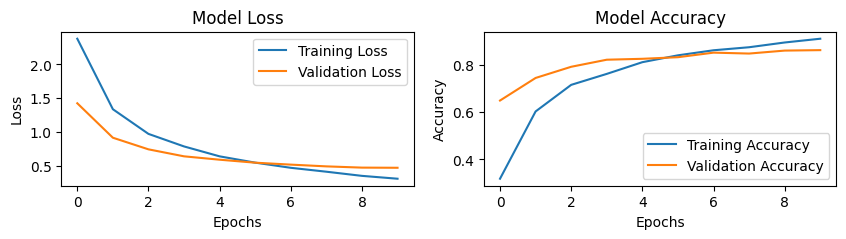

In [22]:
plot_training_history(history.history)

 5/17 [=======>......................] - ETA: 21s - loss: 0.2304 - accuracy: 0.9297

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


17/17 [==============================] - 37s 2s/step - loss: 0.4839 - accuracy: 0.8567
Loss 0.48389479517936707
Accuracy 0.8567307591438293
17/17 [==============================] - 35s 2s/step
F1 score: 0.8570902803718333


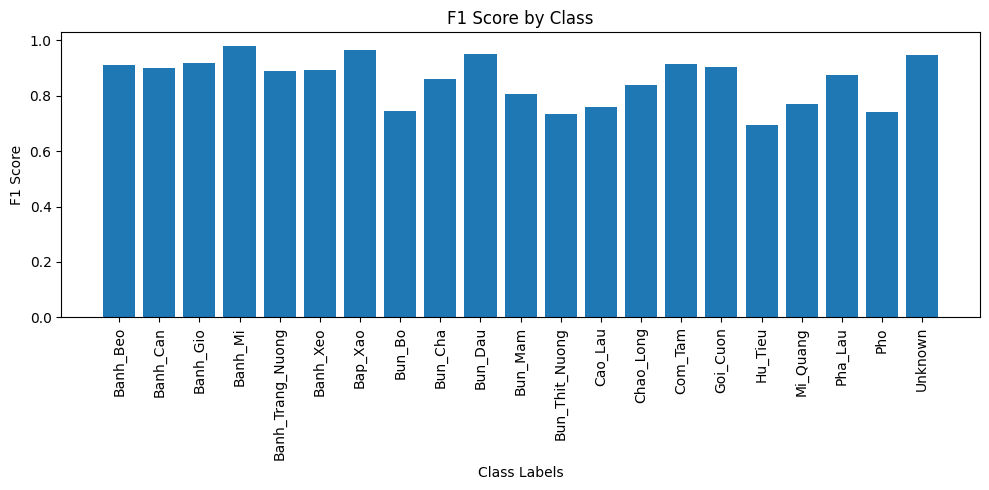

In [23]:
evaluation(resnet_model)

# InceptionResNet V2

In [8]:
from tensorflow.keras.applications import InceptionResNetV2

intres = get_model_instance(InceptionResNetV2, (299, 299, 3))

219055592/219055592 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 8, 8, 1536)        54336736  
 ional)                                                          
                                                                 
 conv2d_203 (Conv2D)         (None, 8, 8, 64)          884800    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (  (None, 64)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               

In [9]:
intres, history = training(intres, 'inception_resnet')

Epoch 1/30


I0000 00:00:1715164406.696331     136 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


61/60 [==============================] - ETA: -2s - loss: 2.2083 - accuracy: 0.3589

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


60/60 [==============================] - 238s 4s/step - loss: 2.2083 - accuracy: 0.3589 - val_loss: 1.3794 - val_accuracy: 0.6490
Epoch 2/30
60/60 [==============================] - 162s 3s/step - loss: 1.3597 - accuracy: 0.5808 - val_loss: 1.0056 - val_accuracy: 0.7252
Epoch 3/30
60/60 [==============================] - 161s 3s/step - loss: 1.0794 - accuracy: 0.6689 - val_loss: 0.8460 - val_accuracy: 0.7493
Epoch 4/30
60/60 [==============================] - 161s 3s/step - loss: 0.9276 - accuracy: 0.7159 - val_loss: 0.7520 - val_accuracy: 0.7927
Epoch 5/30
60/60 [==============================] - 161s 3s/step - loss: 0.8234 - accuracy: 0.7481 - val_loss: 0.7007 - val_accuracy: 0.8062
Epoch 6/30
60/60 [==============================] - 161s 3s/step - loss: 0.7485 - accuracy: 0.7672 - val_loss: 0.6530 - val_accuracy: 0.8216
Epoch 7/30
60/60 [==============================] - 159s 3s/step - loss: 0.6844 - accuracy: 0.7892 - val_loss: 0.6580 - val_accuracy: 0.8197
Epoch 8/30
60/60 [======

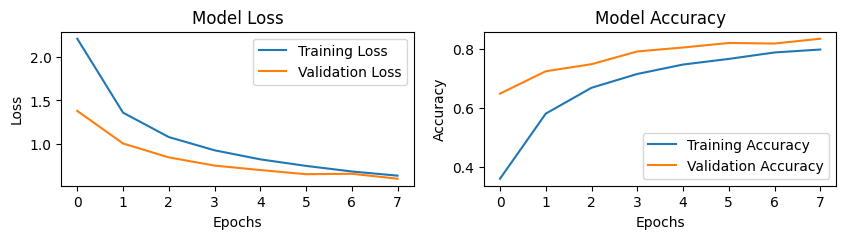

In [10]:
plot_training_history(history.history)

 5/17 [=======>......................] - ETA: 26s - loss: 0.3599 - accuracy: 0.8875

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


17/17 [==============================] - 45s 3s/step - loss: 0.6106 - accuracy: 0.8111
Loss 0.6105619072914124
Accuracy 0.8110576868057251
17/17 [==============================] - 34s 2s/step
F1 score: 0.8119906131863087


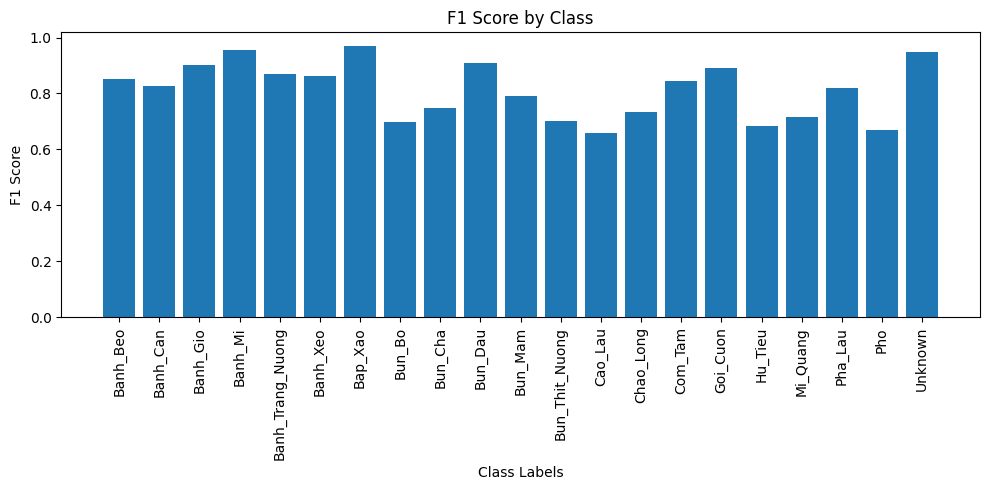

In [11]:
evaluation(intres)

# Confusion matrix

In [11]:
classes = ['Banh_Beo', 'Banh_Can', 'Banh_Gio', 'Banh_Mi', 'Banh_Trang_Nuong', 'Banh_Xeo', 'Bap_Xao', 'Bun_Bo', 'Bun_Cha', 'Bun_Dau', 'Bun_Mam', 'Bun_Thit_Nuong', 'Cao_Lau', 'Chao_Long', 'Com_Tam', 'Goi_Cuon', 'Hu_Tieu', 'Mi_Quang', 'Pha_Lau', 'Pho', 'Unknown']

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import cv2
import random
import itertools
import os

from sklearn.metrics import confusion_matrix, accuracy_score


In [14]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)

In [15]:

test_num = test_generator.samples
label_test = []
for i in range((test_num // test_generator.batch_size)+1):
    X,y = test_generator.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)
label_test.shape

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(2080,)

In [11]:
ineference_model =load_model("/kaggle/input/f_model/tensorflow2/f_model/1/Model/DoAn/resnet.h5")

In [16]:
pred_test = np.argmax(model.predict(test_generator), axis=1)

17/17 [==============================] - 29s 2s/step


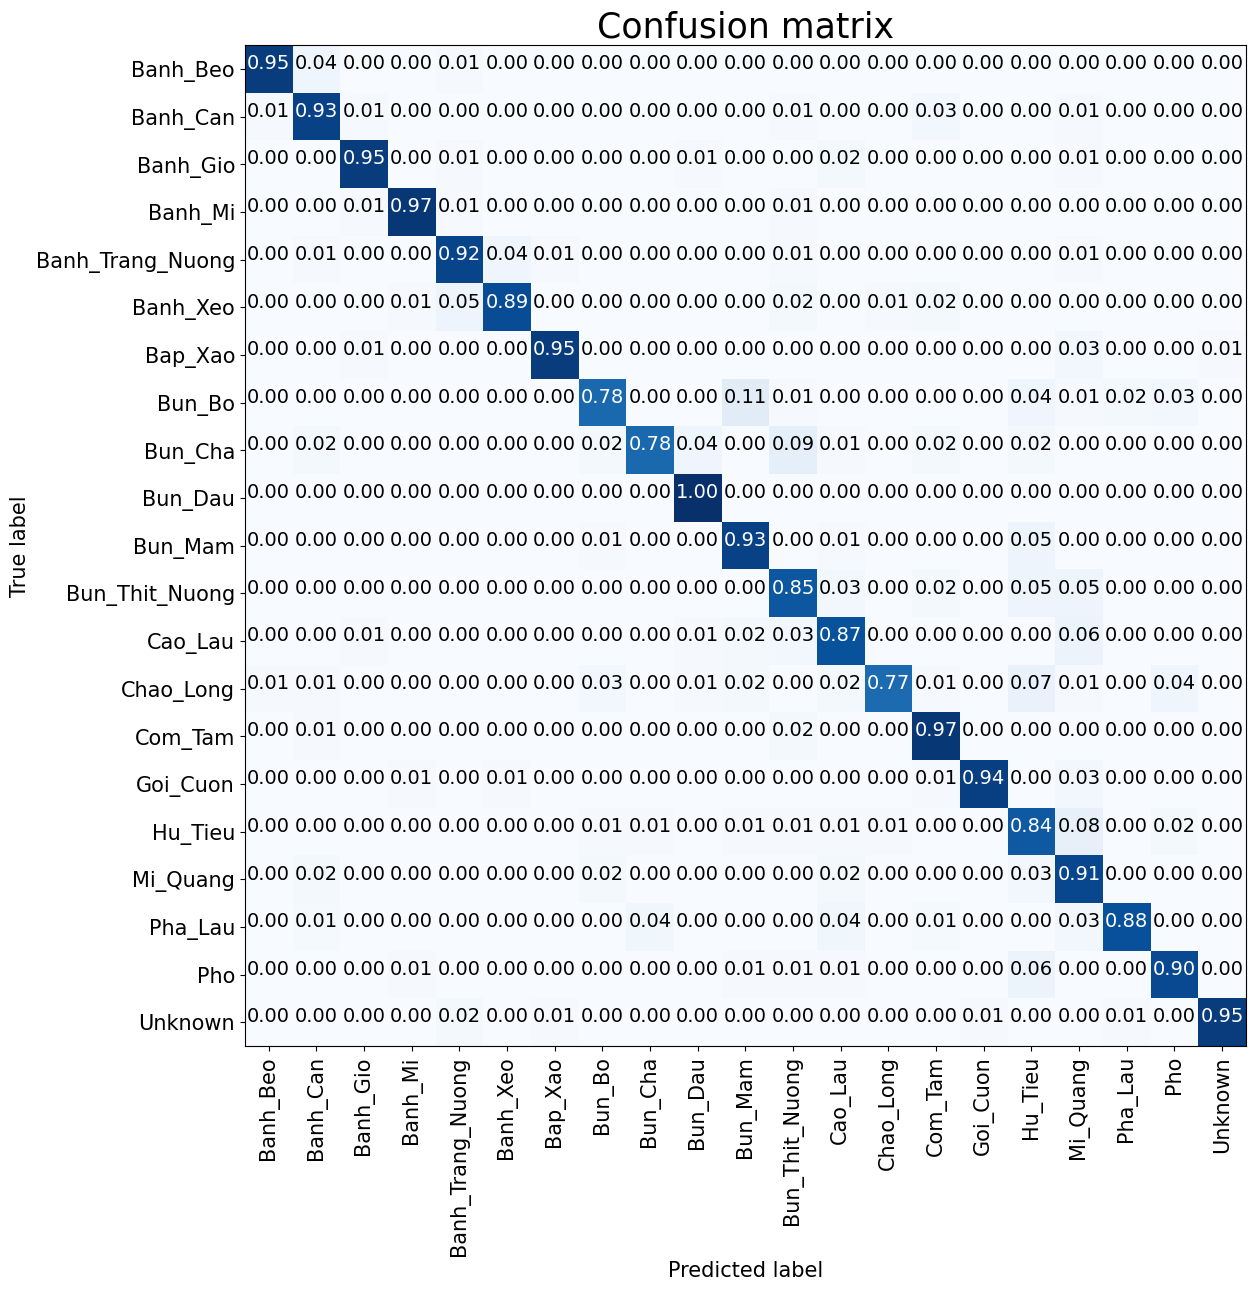

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
cnf_matrix = confusion_matrix(label_test, pred_test)
plt.figure(figsize=(13,13))
plot_confusion_matrix(cnf_matrix, classes=['Banh_Beo', 'Banh_Can', 'Banh_Gio', 'Banh_Mi', 'Banh_Trang_Nuong', 'Banh_Xeo', 'Bap_Xao', 'Bun_Bo', 'Bun_Cha', 'Bun_Dau', 'Bun_Mam', 'Bun_Thit_Nuong', 'Cao_Lau', 'Chao_Long', 'Com_Tam', 'Goi_Cuon', 'Hu_Tieu', 'Mi_Quang', 'Pha_Lau', 'Pho', 'Unknown'])
plt.savefig('/kaggle/working/history/out.svg', format='svg', bbox_inches='tight')
plt.show()